# Match Score and Win Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# Load the data
ipl = pd.read_csv('ipl_data.csv')

In [4]:
# Dropping certain features and keeping only necessary ones
df = ipl.drop(['date', 'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5', 'mid', 'striker', 'non-striker'], axis=1)
df = df[['venue', 'bat_team', 'bowl_team', 'total']]  # Keep only required features

In [5]:
X = df.drop(['total'], axis=1)
y = df['total']

In [6]:
# Label Encoding
venue_encoder = LabelEncoder()
batting_team_encoder = LabelEncoder()
bowling_team_encoder = LabelEncoder()

X['venue'] = venue_encoder.fit_transform(X['venue'])
X['bat_team'] = batting_team_encoder.fit_transform(X['bat_team'])
X['bowl_team'] = bowling_team_encoder.fit_transform(X['bowl_team'])

In [7]:
# Train test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Scaling only the relevant features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 58.3414 - val_loss: 22.0749
Epoch 2/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 22.3811 - val_loss: 22.0718
Epoch 3/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 22.2434 - val_loss: 22.2715
Epoch 4/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 22.1632 - val_loss: 22.0781
Epoch 5/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 22.3490 - val_loss: 21.8931
Epoch 6/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 22.3022 - val_loss: 21.8816
Epoch 7/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 22.2006 - val_loss: 21.9232
Epoch 8/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 21.9681 - val_loss: 21.8328
Epoch 9/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 22.2832 - val_loss: 22.1751
Epoch 10/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 22.1271 - val_loss: 21.7987
Epoch 11/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 22.2001 - val_loss: 21.8308
Epoch 12/50
832/832 ━━━━━━━━━

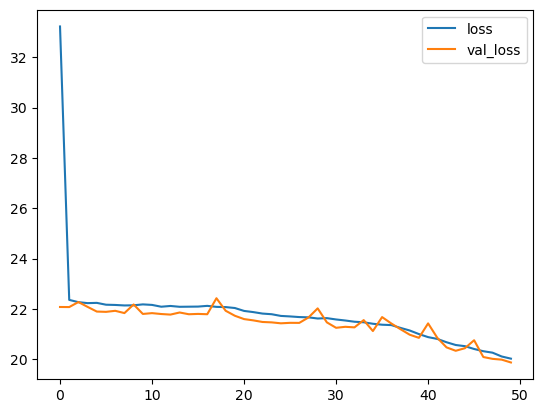

In [9]:
# Define the neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),  # Input layer
    keras.layers.Dense(512, activation='relu'),  # Hidden layer with 512 units and ReLU activation
    keras.layers.Dense(216, activation='relu'),  # Hidden layer with 216 units and ReLU activation
    keras.layers.Dense(1, activation='linear')  # Output layer with linear activation for regression
])

# Compile the model with Huber loss
huber_loss = tf.keras.losses.Huber(delta=1.0)  # You can adjust the 'delta' parameter as needed
model.compile(optimizer='adam', loss=huber_loss)  # Use Huber loss for regression

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test))

model_losses = pd.DataFrame(model.history.history)
model_losses.plot()
plt.show()

In [11]:
import ipywidgets as widgets
from IPython.display import display, clear_output

import warnings
warnings.filterwarnings("ignore")

venue = widgets.Dropdown(options=df['venue'].unique().tolist(), description='Select Venue:')
team1 = widgets.Dropdown(options=df['bat_team'].unique().tolist(), description='Select Team 1:')
team2 = widgets.Dropdown(options=df['bat_team'].unique().tolist(), description='Select Team 2:')

predict_team1_button = widgets.Button(description="Predict Team 1 Score")
predict_team2_button = widgets.Button(description="Predict Team 2 Score")
result_button = widgets.Button(description="Show Result")

output = widgets.Output()

display(venue, team1, team2, predict_team1_button, predict_team2_button, result_button, output)

team1_score = 0
team2_score = 0

def predict_team_score(team, opponent_team, is_team1=True):
    with output:
        clear_output()  # Clear the previous output

        # Encode the input values
        venue_val = venue_encoder.transform([venue.value])[0]
        team_val = batting_team_encoder.transform([team.value])[0]
        opponent_team_val = batting_team_encoder.transform([opponent_team.value])[0]

        # Create input array
        input_data = np.array([venue_val, team_val, opponent_team_val])
        input_data = input_data.reshape(1, -1)
        input_data = scaler.transform(input_data)

        # Predict score
        predicted_score = model.predict(input_data)
        predicted_score = int(predicted_score[0, 0])

        # Display the predicted score
        print(f"{team.value} predicted score: {predicted_score}")
        return predicted_score

def predict_team1_score(b):
    global team1_score
    team1_score = predict_team_score(team1, team2, is_team1=True)

def predict_team2_score(b):
    global team2_score
    team2_score = predict_team_score(team2, team1, is_team1=False)

def predict_final_result(b):
    with output:
        clear_output()
        print(f"Team 1: {team1.value} predicted score: {team1_score}")
        print(f"Team 2: {team2.value} predicted score: {team2_score}")

        if team1_score > team2_score:
            print(f"{team1.value} wins!")
        elif team2_score > team1_score:
            print(f"{team2.value} wins!")
        else:
            print("It's a tie!")

predict_team1_button.on_click(predict_team1_score)
predict_team2_button.on_click(predict_team2_score)
result_button.on_click(predict_final_result)

Dropdown(description='Select Venue:', options=('M Chinnaswamy Stadium', 'Punjab Cricket Association Stadium, M…

Dropdown(description='Select Team 1:', options=('Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Roy…

Dropdown(description='Select Team 2:', options=('Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Roy…

Button(description='Predict Team 1 Score', style=ButtonStyle())

Button(description='Predict Team 2 Score', style=ButtonStyle())

Button(description='Show Result', style=ButtonStyle())

Output()

# Analysis

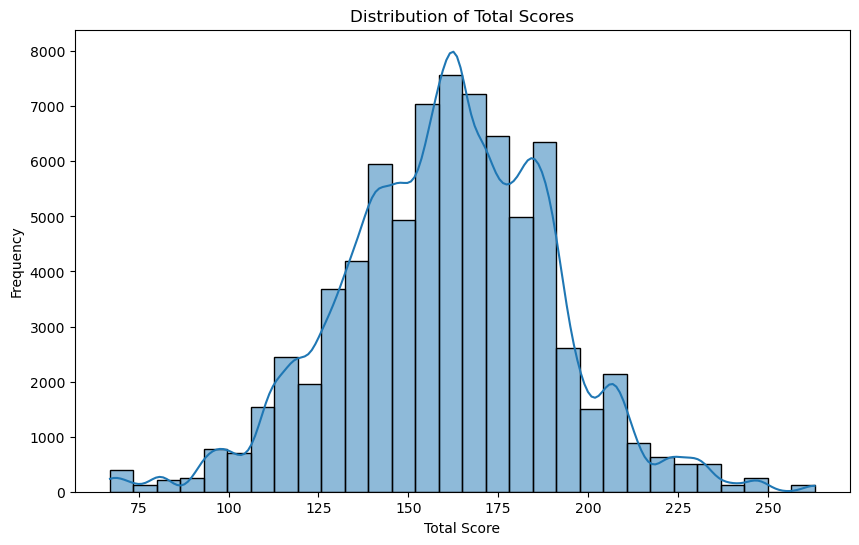

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Total Scores
plt.figure(figsize=(10, 6))
sns.histplot(df['total'], bins=30, kde=True)
plt.title('Distribution of Total Scores')
plt.xlabel('Total Score')
plt.ylabel('Frequency')
plt.show()

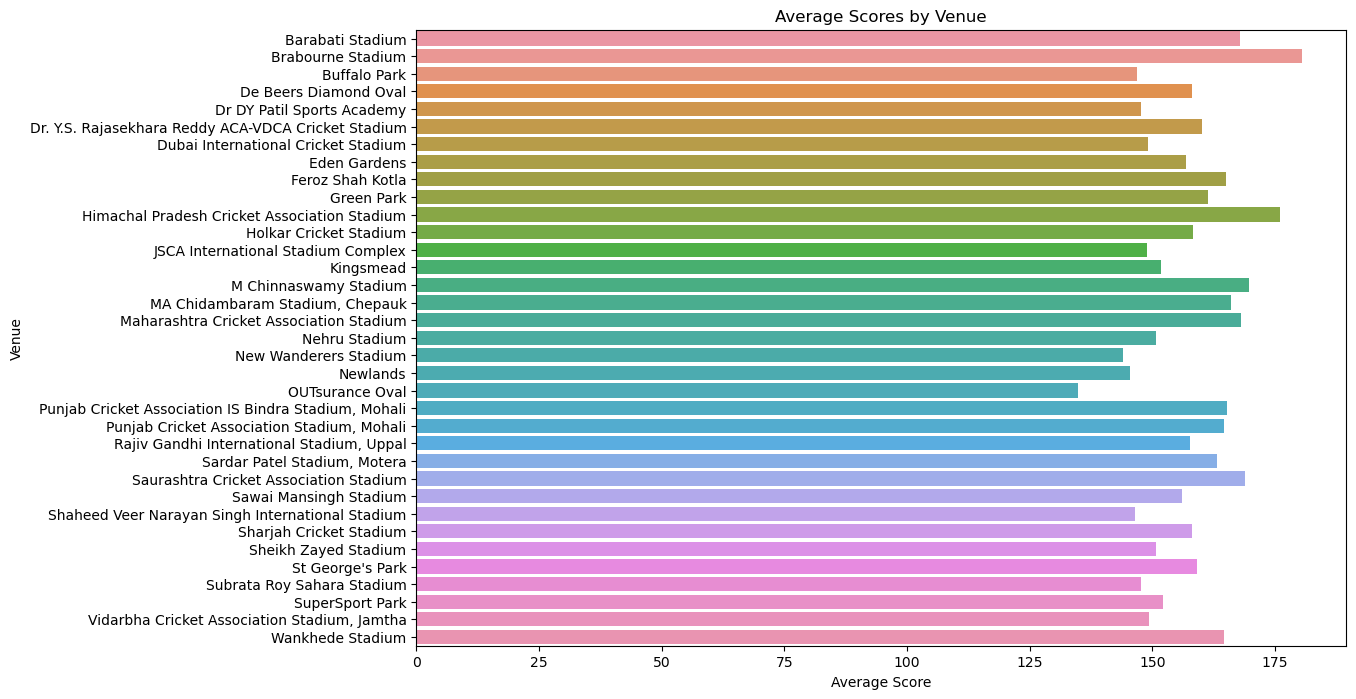

In [19]:
# Average Scores by Venue
venue_scores = df.groupby('venue')['total'].mean().reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(data=venue_scores, x='total', y='venue')
plt.title('Average Scores by Venue')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()

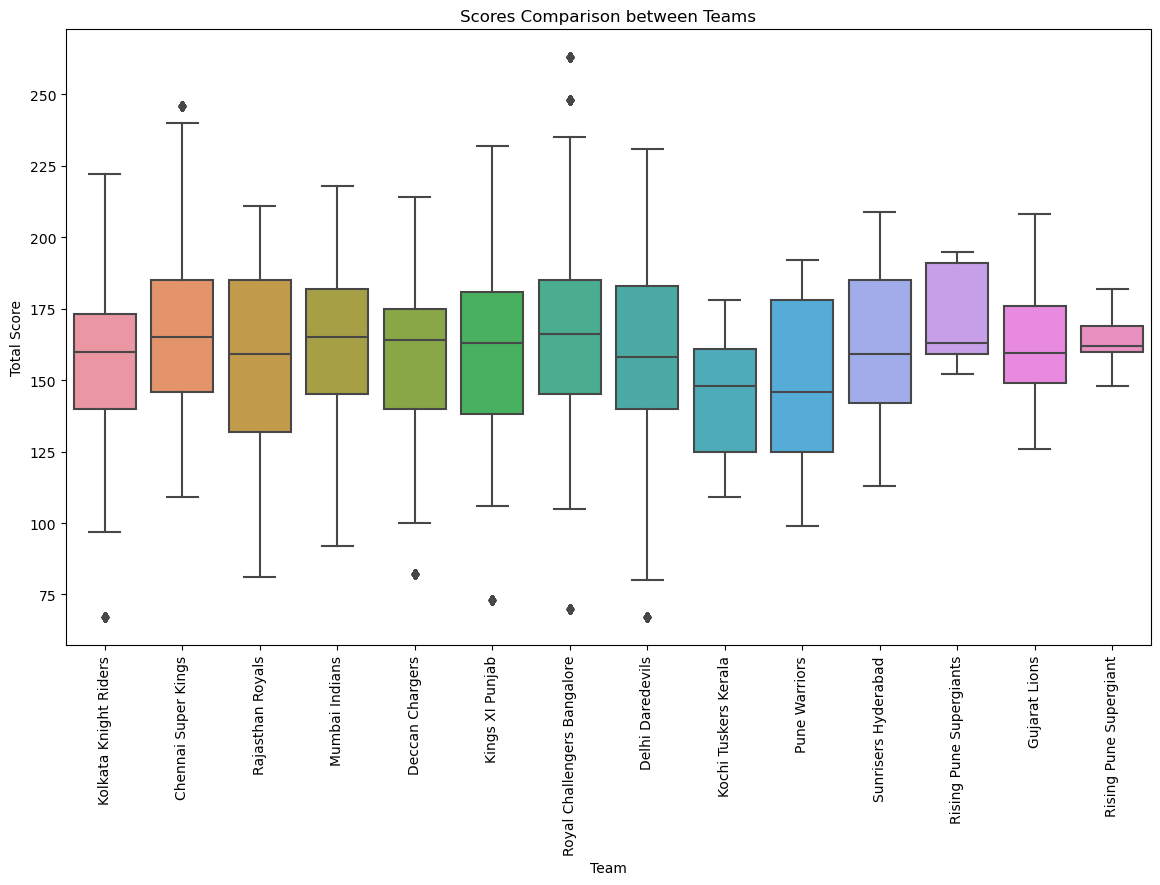

In [23]:
# Scores Comparison between Teams
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='bat_team', y='total')
plt.title('Scores Comparison between Teams')
plt.xlabel('Team')
plt.ylabel('Total Score')
plt.xticks(rotation=90)
plt.show()

713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


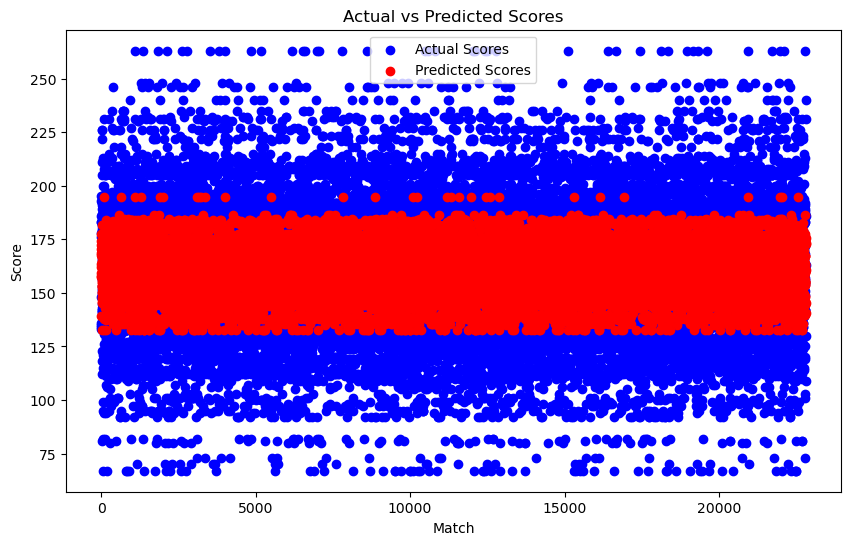

In [14]:
# Assuming you have the predicted scores from previous steps
predictions = model.predict(X_test_scaled)

# Scatter plot of predicted scores
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Scores')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted Scores')
plt.title('Actual vs Predicted Scores')
plt.xlabel('Match')
plt.ylabel('Score')
plt.legend()
plt.show()

<Figure size 1400x800 with 0 Axes>

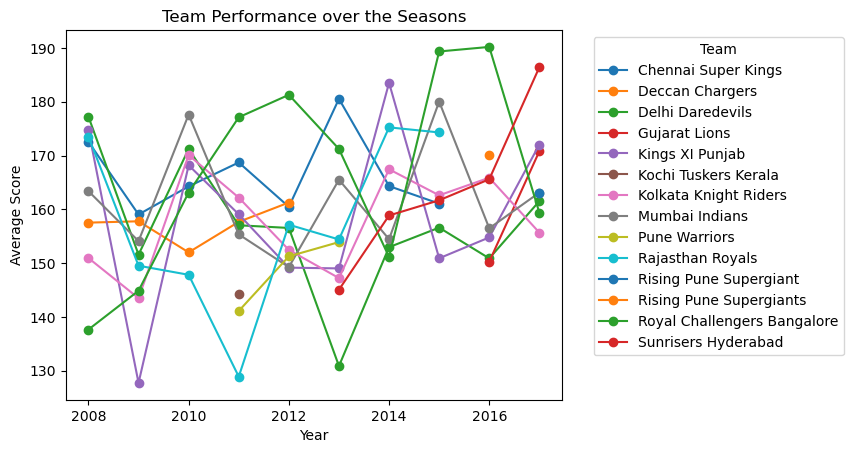

In [15]:
# Assuming the 'date' column is included in your dataset
df['year'] = pd.to_datetime(ipl['date']).dt.year

# Average Scores by Year for each Team
team_yearly_performance = df.groupby(['year', 'bat_team'])['total'].mean().unstack()

plt.figure(figsize=(14, 8))
team_yearly_performance.plot(kind='line', marker='o')
plt.title('Team Performance over the Seasons')
plt.xlabel('Year')
plt.ylabel('Average Score')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
